In [49]:
! pip install pyspark py4j

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [50]:
from pyspark.sql import SparkSession

In [51]:
spark = SparkSession.builder.appName("firstapp").getOrCreate()

In [52]:
df = spark.read.csv('/week_1_output.csv', header = True,inferSchema = True) #header = True,
#inferSchema = True - means tht all values will be given thier correct schema, otherwise it will give all as string 

In [53]:
df.show(5)

+----------+---------------+-----------------+------------------+--------+-------------+---------------+----------------+----------------+--------------------+----------------------+-----------------------+--------------+--------------------+--------------------+---------------------+-------+----------+-----------------+-------------+-----------+------------------+
|start_time|start time hour|start time minute|start time seconds|end_time|end_time hour|end_time minute|end_time seconds|start_station_id|  start_station_name|start_station_latitude|start_station_longitude|end_station_id|    end_station_name|end_station_latitude|end_station_longitude|bike_id| user_type|member_birth_year|member_gender|     pyment|haversine_distance|
+----------+---------------+-----------------+------------------+--------+-------------+---------------+----------------+----------------+--------------------+----------------------+-----------------------+--------------+--------------------+--------------------+-

In [54]:
df.columns

['start_time',
 'start time hour',
 'start time minute',
 'start time seconds',
 'end_time',
 'end_time hour',
 'end_time minute',
 'end_time seconds',
 'start_station_id',
 'start_station_name',
 'start_station_latitude',
 'start_station_longitude',
 'end_station_id',
 'end_station_name',
 'end_station_latitude',
 'end_station_longitude',
 'bike_id',
 'user_type',
 'member_birth_year',
 'member_gender',
 'pyment',
 'haversine_distance']

In [169]:
#df.count() #returns number of rows in data 

In [170]:
#df.select(['bike_id', 'user_type']).show(3) #you select just the columns you want to see
#df.describe().show()

**From week2.task1**: task1-calculate the duration in seconds of each trip ( I formed a new column as trip, by substracting endtime and start time), however, we can also get same answer by also assuming that every row is a trip 

In [55]:
df1 = df.withColumn('start_time(s)', df[1]*3600 + df[2]*60 + df[3])
df2 = df1.withColumn('end_time(s)', df[5]*3600 + df[6]*60 + df[7])

#df2.show(['start_time(s)','end_time(s)'])

In [56]:
df3 = df2.withColumn('trip(s)', (df2['end_time(s)'] - df2['start_time(s)']))
#display('trip(s)')

### **Week3:task1:** calculate the number of trips for each start station list top 10 and find the ratio of using as male or female 

In [57]:
df.groupby('member_gender').count().show()

+-------------+------+
|member_gender| count|
+-------------+------+
|       Female| 98621|
|        Other|  6299|
|         Male|348318|
|         null| 66462|
+-------------+------+



In [87]:
import pyspark.sql.functions as F
#df = df.withColumn('test_column_1', F.when(F.col('member_gender' == 'Female') , 0).otherwise(1))
df11 = df3.withColumn('F', F.when(F.col('member_gender') == 'Female', 1).otherwise(0)).withColumn('M', F.when(F.col('member_gender') == 'Male', 1).otherwise(0))

df11.select('F', 'M','member_gender').show(10)

+---+---+-------------+
|  F|  M|member_gender|
+---+---+-------------+
|  0|  1|         Male|
|  1|  0|       Female|
|  0|  0|         null|
|  0|  0|         null|
|  1|  0|       Female|
|  0|  0|         null|
|  1|  0|       Female|
|  0|  0|         null|
|  0|  0|         null|
|  0|  0|         null|
+---+---+-------------+
only showing top 10 rows



In [88]:
#df_new = df3.groupby('start_station_name').count(df.trip(s)).show()

#Using agg count
from pyspark.sql.functions import desc

df4 = df11.groupBy('start_station_id').agg({'trip(s)':'count', 'F':'sum', 'M': 'sum'}).orderBy(desc('count(trip(s))')).head(10)

In [85]:
#df_new = df3.groupby('start_station_name').count(df.trip(s)).show()

#Using agg count
from pyspark.sql.functions import desc
df4 = df11.groupBy('start_station_id').agg({'trip(s)':'count', 'F':'sum', 'M': 'sum'}).orderBy(desc('count(trip(s))')).limit(10)

In [86]:
df5 = df4.withColumn('ratio', df4[1]/df4[2])
df5.show()

+----------------+------+------+--------------+-------------------+
|start_station_id|sum(F)|sum(M)|count(trip(s))|              ratio|
+----------------+------+------+--------------+-------------------+
|              15|  2819|  8586|         15187| 0.3283251805264384|
|               6|  1938|  7444|         13664| 0.2603439011284256|
|              30|  2035|  9813|         12546| 0.2073779680016305|
|              67|  2105|  9409|         12055| 0.2237219683281964|
|              58|  1870|  9005|         11960| 0.2076624097723487|
|              21|  1631|  8367|         11334| 0.1949324728098482|
|              81|  2302|  7773|         10956| 0.2961533513443973|
|               3|  1768|  6070|         10142| 0.2912685337726524|
|              22|  1980|  7512|          9926|0.26357827476038337|
|              16|  1740|  6532|          9347|0.26638089406001225|
+----------------+------+------+--------------+-------------------+



In [63]:
df4 = df3.groupBy('start_station_id').count().orderBy(desc('count')).show(10)

+----------------+-----+
|start_station_id|count|
+----------------+-----+
|              15|15187|
|               6|13664|
|              30|12546|
|              67|12055|
|              58|11960|
|              21|11334|
|              81|10956|
|               3|10142|
|              22| 9926|
|              16| 9347|
+----------------+-----+
only showing top 10 rows



task2: make a comparison to find the percentage of usage for customer and subscriber

In [64]:
df1 = df.groupby('user_type').count().limit(2)
df1.show()


+----------+------+
| user_type| count|
+----------+------+
|Subscriber|409230|
|  Customer|110470|
+----------+------+



In [65]:
nb_subs = df1.take(1)[0][1]
cust =  df1.take(2)[1][1] 
percentage_subs = nb_subs*100/(nb_subs+cust)
percentage_subs
#specific_value = df.take(3)[2][4]
#This will retrieve the first 3 rows of the DataFrame df and select the 3rd row (at index 2 in the list of rows), and then select the 5th column (at index 4 in the list of columns). Note that indexing in PySpark is 0-based, so the 3rd row has an index of 2.

78.74350586877044

In [66]:
percentage_cust = cust*100/(nb_subs+cust)
percentage_cust

21.256494131229555

week3,task3: calculate the age of all users and show the relation between the distance and the age

In [120]:
from pyspark.sql import functions as F
from pyspark.sql import types as T
from datetime import datetime

df12 = df1.withColumn("age", F.floor(F.datediff(F.current_timestamp(), F.col("member_birth_year"))/365.25))
df12_new = df12.na.drop(how= "any", subset = ["age"])
df12_new.select("age","member_birth_year",).show(5)

+---+-----------------+
|age|member_birth_year|
+---+-----------------+
| 36|             1987|
| 58|             1965|
| 26|             1997|
| 32|             1991|
| 33|             1990|
+---+-----------------+
only showing top 5 rows



In [113]:
df12_new = df12.groupby("age").agg({"haversine_distance": "mean"})
df12_new.show(3)

+---+-----------------------+
|age|avg(haversine_distance)|
+---+-----------------------+
| 26|      1.349312818936619|
| 29|     1.5988107774927172|
| 65|     1.5599574059975367|
+---+-----------------------+
only showing top 3 rows



In [110]:
# convert to pandas and plot
pdf = df12_new.toPandas()

In [104]:
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt

Text(0, 0.5, 'haversine_distance')

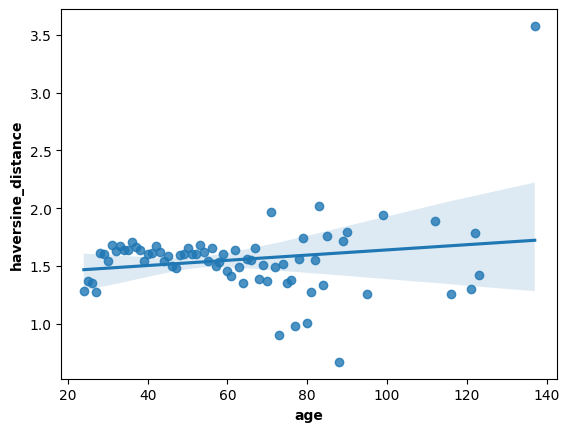

In [118]:
sn.regplot(x= "age", y= "avg(haversine_distance)", data=pdf)
plt.xlabel('age', weight = 'bold')
plt.ylabel('haversine_distance', weight = 'bold')